# RTX 4080 CNN Benchmark

Purpose:
- This notebook is intended to benchmark the performance of the RTX 4080 GPU using 3 different CNNs: ResNet, EfficientNet, ViT, and SwinT.
- The models are pre-trained on ImageNet, and will be fine-tuned for the brain tumor dataset from Kaggle

Sources:
- https://medium.com/@enrico.randellini/image-classification-resnet-vs-efficientnet-vs-efficientnet-v2-vs-compact-convolutional-c205838bbf49
- https://github.com/enrico310786/brain_tumor_classification/tree/master
- https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri/data

In [1]:
import random
import shutil
import os
import time
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import cv2
import albumentations as A


/home/keegan-jebb/miniconda3/envs/ai/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.14 (you have 1.4.11). Upgrade using: pip install --upgrade albumentations


In [2]:
import logging

class Logger():
    def __init__(self, exp_path) -> None:

        logging.basicConfig(filename=os.path.join(exp_path, 'training.log'),
                            format='%(asctime)s %(levelname)s %(message)s',
                            level=logging.INFO,
                            datefmt='%Y-%m-%d %H:%M:%S')

    def log(self, text):
        logging.info(text)

## Preprocessing

In [3]:

#path_of original dataset
path_original_dataset_train = "./data/original/Training"
path_original_dataset_test = "./data/original/Testing"

#path of final dataset
root = "./data/preprocessed"
path_dataset_train = os.path.join(root, 'train')
path_dataset_test = os.path.join(root, 'test')
path_dataset_val = os.path.join(root, 'val')

# path of csv files
path_csv_train = os.path.join(root, 'train.csv')
path_csv_test = os.path.join(root, 'test.csv')
path_csv_val = os.path.join(root, 'val.csv')

percent_train = 0.8

df_train = pd.DataFrame(columns=['CLASS', 'PATH', 'LABEL'])
df_test = pd.DataFrame(columns=['CLASS', 'PATH', 'LABEL'])
df_val = pd.DataFrame(columns=['CLASS', 'PATH', 'LABEL'])


def clean_create_dir(path_dir):
    if os.path.isdir(path_dir):
        print("The directory '{}' exists. Delete it".format(path_dir))
        try:
            shutil.rmtree(path_dir)
        except OSError as e:
            print("Error: {}".format(e.strerror))
            raise e

        if not os.path.isdir(path_dir):
            print("Create the directory '{}'".format(path_dir))
            os.makedirs(path_dir)
    else:
        print("Create the directory '{}'".format(path_dir))
        os.makedirs(path_dir)


def make_train_val_division(path_original_dataset, path_dataset_train, path_dataset_val):

    list_cls = []
    print("Train/Val Split")

    for subdir, dirs, files in os.walk(path_original_dataset):
        for cl in dirs:
            path_cl = os.path.join(path_original_dataset, cl)
            if os.path.isdir(path_cl):
                print("class_name: ", cl)
                list_cls.append(cl)
                list_filenames_cl = os.listdir(path_cl)
                number_files = len(list_filenames_cl)
                index_list = [i for i in range(number_files)]
                print("number_files in directory '{}': {}".format(path_cl, number_files))

                number_file_train = round(number_files * percent_train)
                train_index_list = random.sample(index_list, k=number_file_train)
                val_index_list = list(set(index_list) - set(train_index_list))

                # copy files in train directory
                dst_dir = os.path.join(path_dataset_train, cl)
                if not os.path.isdir(dst_dir):
                    os.makedirs(dst_dir)
                for idx in train_index_list:
                    filename = list_filenames_cl[idx]
                    src_file = os.path.join(path_cl, filename)
                    dst_file = os.path.join(dst_dir, filename)
                    shutil.copy2(src_file, dst_file)
                print("Number of files in dir '{}': {}".format(dst_dir, len(os.listdir(dst_dir))))

                # copy files in val directory
                dst_dir = os.path.join(path_dataset_val, cl)
                if not os.path.isdir(dst_dir):
                    os.makedirs(dst_dir)
                for idx in val_index_list:
                    filename = list_filenames_cl[idx]
                    src_file = os.path.join(path_cl, filename)
                    dst_file = os.path.join(dst_dir, filename)
                    shutil.copy2(src_file, dst_file)
                print("Number of files in dir '{}': {}".format(dst_dir, len(os.listdir(dst_dir))))
                print('----------------------------------------------------------------')

    return list_cls


def create_csv(path_dataset, df, class_to_label, type_dataset):
    for subdir, dirs, files in os.walk(path_dataset):
        for cl in dirs:
            path_cl = os.path.join(path_dataset, cl)
            if os.path.isdir(path_cl):
                print("class_name: ", cl)
                label = class_to_label[cl]
                filenames = os.listdir(path_cl)
                for file_name in filenames:
                    relative_path = os.path.join(type_dataset, cl, file_name)
                    df.loc[len(df)] = [cl, relative_path, label]

    return df

In [4]:
list_cls = []
for subdir, dirs, files in os.walk(path_original_dataset_test):
    for cl in dirs:
        path_cl = os.path.join(path_original_dataset_test, cl)
        if os.path.isdir(path_cl):
            list_cls.append(cl)

class_to_label = {k: v for (v, k) in enumerate(list_cls)}
print(class_to_label)

{'meningioma_tumor': 0, 'pituitary_tumor': 1, 'no_tumor': 2, 'glioma_tumor': 3}


In [5]:
# 1 - clean and create the dataset directory
clean_create_dir(root)

# 2 - copy in the dataset directory the "Testing" dataset renaming it as Test
shutil.copytree(path_original_dataset_test, path_dataset_test)

# 3 - do split train/val of the train dataset
list_cls = make_train_val_division(path_original_dataset_train, path_dataset_train, path_dataset_val)
class_to_label = {k: v for (v, k) in enumerate(list_cls)}

print('-----------------------------------------------')
print('-----------------------------------------------')

print("list_cls: ", list_cls)
print("")
print("class_to_label: ", class_to_label)

print('-----------------------------------------------')
print('-----------------------------------------------')

# 4 - create csv files
print("Create csv files")
print("Train set")
df_train = create_csv(path_dataset_train, df_train, class_to_label, "train")
print("Test set")
df_test = create_csv(path_dataset_test, df_test, class_to_label, "test")
print("Val set")
df_val = create_csv(path_dataset_val, df_val, class_to_label, "val")

print('-------------------------------------------------------------')
print('-------------------------------------------------------------')

# 5 -  shuffling and saving of csv
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)

df_train.to_csv(path_csv_train, index=False)
df_test.to_csv(path_csv_test, index=False)
df_val.to_csv(path_csv_val, index=False)

print("df_train info")
print(df_train.info())
print('-------------------------------------------------------------')
print("")
print("df_test info")
print(df_test.info())
print('-------------------------------------------------------------')
print("")
print("df_val info")
print(df_val.info())

print('-------------------------------------------------------------')
print("df_train:  CLASS values count")
print(df_train[["CLASS"]].value_counts())
print('-------------------------------------------------------------')
print("df_test:  CLASS values count")
print(df_test[["CLASS"]].value_counts())
print('-------------------------------------------------------------')
print("df_val:  CLASS values count")
print(df_val[["CLASS"]].value_counts())

The directory './data/preprocessed' exists. Delete it
Create the directory './data/preprocessed'
Train/Val Split
class_name:  meningioma_tumor
number_files in directory './data/original/Training/meningioma_tumor': 822
Number of files in dir './data/preprocessed/train/meningioma_tumor': 658
Number of files in dir './data/preprocessed/val/meningioma_tumor': 164
----------------------------------------------------------------
class_name:  pituitary_tumor
number_files in directory './data/original/Training/pituitary_tumor': 827
Number of files in dir './data/preprocessed/train/pituitary_tumor': 662
Number of files in dir './data/preprocessed/val/pituitary_tumor': 165
----------------------------------------------------------------
class_name:  no_tumor
number_files in directory './data/original/Training/no_tumor': 395
Number of files in dir './data/preprocessed/train/no_tumor': 316
Number of files in dir './data/preprocessed/val/no_tumor': 79
-----------------------------------------------

## Data Augmentation

In [6]:
transform = A.Compose([
    A.HueSaturationValue(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p=0.5),
    A.Flip(p=0.5),
    A.Rotate(p=0.5),
    A.MultiplicativeNoise(multiplier=[0.5, 1.5], elementwise=True, per_channel=True, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, rotate_limit=45, p=0.5),
    A.Transpose(p=0.5),
])


def make_data_augmentation(path_original_dataset, path_augmented_dataset, root_csv, training_sample_target, df, class_to_label):
    #iter over directory
    for subdir, dirs, files in os.walk(path_original_dataset):
        for cl in dirs:
            path_class = os.path.join(path_original_dataset, cl)
            if os.path.isdir(path_class):
                label = class_to_label[cl]
                print("CLASS: {}  - LABEL: {}".format(cl, label))
                number_files = len(os.listdir(path_class))
                print("number_files in directory '{}': {}".format(path_class, number_files))

                path_directory_save = os.path.join(path_augmented_dataset, cl)
                path_directory_save_for_csv = os.path.join(root_csv, cl)
                if not os.path.isdir(path_directory_save):
                    print("Create dir directory '{}'".format(path_directory_save))
                    os.makedirs(path_directory_save)

                n_applications = round((training_sample_target-number_files)/number_files)
                if n_applications < 0:
                    n_applications = 0
                print('n_applications: ', n_applications)

                for filename in os.listdir(path_class):
                    path_image = os.path.join(path_class, filename)
                    image = cv2.imread(path_image)
                    filename_no_ext, extension= filename.split(".")[0], filename.split(".")[-1]

                    # copy the original image from the source dir to the dest dir
                    dst_file = os.path.join(path_directory_save, filename)
                    shutil.copy2(path_image, dst_file)
                    df.loc[len(df)] = [cl, os.path.join(path_directory_save_for_csv, filename), label]

                    for i in range(n_applications):
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                        augmented_image = transform(image=image)['image']
                        augmented_image = cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR)
                        new_file_name = filename_no_ext + '_' + str(i+1) + '.' + extension
                        dst_file = os.path.join(path_directory_save, new_file_name)

                        cv2.imwrite(dst_file, augmented_image)
                        df.loc[len(df)] = [cl, os.path.join(path_directory_save_for_csv, new_file_name), label]

                final_number_files = len(os.listdir(path_directory_save))
                print("Final number of files on dir '{}': {}".format(path_directory_save, final_number_files))
                print("---------------------------------------------")

    return df

In [7]:
training_sample_target = 5000

#path of final dataset
root = "./data/preprocessed"
augmented_label = "train_augmented"
path_augmented_dataset_train = os.path.join(root, 'train_augmented')
path_augmented_csv_train = os.path.join(root, 'train_augmented.csv')
df_train_augmented = pd.DataFrame(columns=['CLASS', 'PATH', 'LABEL'])
root_csv = "train_augmented"

# 1 - clean and create the dataset directory
clean_create_dir(path_augmented_dataset_train)

# 2 - make data augmentation
print("Data augmentation")
print("Train set")
df_train_augmented = make_data_augmentation(path_dataset_train, path_augmented_dataset_train, root_csv, training_sample_target, df_train_augmented, class_to_label)

# 3 - create new csv
df_train_augmented = df_train_augmented.sample(frac=1).reset_index(drop=True)
df_train_augmented.to_csv(path_augmented_csv_train, index=False)
print("df_train info")
print(df_train_augmented.info())
print('-------------------------------------------------------------')
print("df_train:  CLASS values count")
print(df_train_augmented[["CLASS"]].value_counts())
print('-------------------------------------------------------------')

Create the directory './data/preprocessed/train_augmented'
Data augmentation
Train set
CLASS: meningioma_tumor  - LABEL: 0
number_files in directory './data/preprocessed/train/meningioma_tumor': 658
Create dir directory './data/preprocessed/train_augmented/meningioma_tumor'
n_applications:  7
Final number of files on dir './data/preprocessed/train_augmented/meningioma_tumor': 5264
---------------------------------------------
CLASS: pituitary_tumor  - LABEL: 1
number_files in directory './data/preprocessed/train/pituitary_tumor': 662
Create dir directory './data/preprocessed/train_augmented/pituitary_tumor'
n_applications:  7
Final number of files on dir './data/preprocessed/train_augmented/pituitary_tumor': 5296
---------------------------------------------
CLASS: no_tumor  - LABEL: 2
number_files in directory './data/preprocessed/train/no_tumor': 316
Create dir directory './data/preprocessed/train_augmented/no_tumor'
n_applications:  15
Final number of files on dir './data/preprocess

## Dataloaders

In [8]:
class ClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, df_dataset, cfg, dataset_path) -> None:
        super().__init__()

        self.df_dataset = df_dataset
        self.dataset_path = dataset_path
        self.cfg = cfg
        self.do_resize = cfg["data"].get("do_resize", 1.0) > 0.0
        if cfg["data"]["normalization"] == "pm1":
            print("Apply pm1 normalization")
            self.normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        elif cfg["data"]["normalization"] == "imagenet":
            print("Apply imagenet normalization")
            self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        elif cfg["data"]["normalization"] == "None":
            print("No normalization to apply")
            self.normalize = None

    def __len__(self):
        return len(self.df_dataset)

    def __getitem__(self, idx):
        img_path = os.path.join(self.dataset_path, self.df_dataset.iloc[idx]["PATH"])
        label = self.df_dataset.iloc[idx]["LABEL"]

        if not os.path.exists(img_path):
            print("The image '{}' does not exist ".format(img_path))

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.do_resize:
            img = cv2.resize(img, (self.cfg["data"]["size"], self.cfg["data"]["size"]))
        img = transforms.ToTensor()(img)
        if self.normalize is not None:
            img = self.normalize(img)

        return img, label


def create_loaders(cfg, df_dataset_train, df_dataset_val, df_dataset_test=None):

    dataset_path = cfg['dataset']['dataset_path']
    batch_size = cfg['dataset']['batch_size']


    classification_dataset_test = None
    classification_dataset_train = ClassificationDataset(df_dataset=df_dataset_train, cfg=cfg, dataset_path=dataset_path)
    classification_dataset_val = ClassificationDataset(df_dataset=df_dataset_val, cfg=cfg, dataset_path=dataset_path)
    if df_dataset_test is not None:
        classification_dataset_test = ClassificationDataset(df_dataset=df_dataset_test, cfg=cfg, dataset_path=dataset_path)


    classification_dataloader_train = DataLoader(dataset=classification_dataset_train,
                                                 batch_size=batch_size,
                                                 shuffle=True,
                                                 num_workers=cfg['dataset']['num_workers'],
                                                 drop_last=False)

    classification_dataloader_val = DataLoader(dataset=classification_dataset_val,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=cfg['dataset']['num_workers'],
                                               drop_last=False)

    classification_dataloader_test = None
    if classification_dataset_test is not None:
        classification_dataloader_test = DataLoader(dataset=classification_dataset_test,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    num_workers=cfg['dataset']['num_workers'],
                                                    drop_last=False)

    return classification_dataloader_train, classification_dataloader_val, classification_dataloader_test

## Models

In [9]:
from torchvision import models
from torchvision.models import ResNet50_Weights, \
    EfficientNet_B4_Weights, EfficientNet_V2_S_Weights, \
    ViT_B_16_Weights, Swin_V2_T_Weights
from torchinfo import summary

class ImageClassificationModel(nn.Module):

    def __init__(self, cfg):
        super().__init__()
        self.num_classes = cfg["model"]["num_classes"]
        self.n_nodes = cfg["model"]["n_nodes"]
        self.dropout = cfg["model"]["dropout"]
        self.freeze_layers = cfg["model"].get("freeze_layers", 1.0) > 0.0
        self.image_size = cfg["data"]["size"]
        self.pretrained = cfg["model"].get("pretrained", 1.0) > 0.0
        self.model = self.get_model(cfg["model"]["name_pretrained_model"])

        print("")
        summary(model=self.model,
                input_size=(1, 3, self.image_size, self.image_size),
                col_names=["input_size", "output_size", "num_params", "trainable"],
                col_width=20,
                row_settings=["var_names"])
        print("")

    def forward(self, x):
        x = self.model(x)
        return x

    def classifier_head(self, output_dim):
        return nn.Sequential(nn.Flatten(),
                             nn.Linear(output_dim, self.n_nodes),
                             nn.ReLU(),
                             nn.Dropout(self.dropout),
                             nn.Linear(self.n_nodes, self.num_classes))

    def freeze_layers_base_model(self, model):
        for name, param in model.named_parameters():
            param.requires_grad = False

    def get_model(self, name_pretrained_model):
        if name_pretrained_model == 'resnet50':
            base_model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
            base_model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

            if self.freeze_layers:
                print("Freeze layers of pretrained model")
                self.freeze_layers_base_model(base_model)

            base_model.fc = self.classifier_head(2048)
        elif name_pretrained_model == 'efficientnet_b4':
            base_model = models.efficientnet_b4(weights=EfficientNet_B4_Weights.DEFAULT)
            base_model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

            if self.freeze_layers:
                print("Freeze layers of pretrained model")
                self.freeze_layers_base_model(base_model)

            base_model.classifier = self.classifier_head(1792)
        elif name_pretrained_model == 'efficientnet_v2_s':
            base_model = models.efficientnet_v2_m(weights=EfficientNet_V2_S_Weights.DEFAULT)
            base_model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

            if self.freeze_layers:
                print("Freeze layers of pretrained model")
                self.freeze_layers_base_model(base_model)

            base_model.classifier = self.classifier_head(1280)
        elif name_pretrained_model == 'vit_b_16':
            base_model = models.vit_b_16(weights=ViT_B_16_Weights.DEFAULT)

            if self.freeze_layers:
                print("Freeze layers of pretrained model")
                self.freeze_layers_base_model(base_model)

            base_model.classifier = self.classifier_head(1280)
        elif name_pretrained_model == 'swin_v2_t':
            base_model = models.swin_v2_t(weights=Swin_V2_T_Weights.DEFAULT)

            if self.freeze_layers:
                print("Freeze layers of pretrained model")
                self.freeze_layers_base_model(base_model)

            base_model.classifier = self.classifier_head(1280)

        return base_model


def find_last_checkpoint_file(checkpoint_dir, use_best_checkpoint=False):
    print("Check for file .pth in checkpoint_dir {}: ".format(checkpoint_dir))
    list_file_paths = []

    for file in os.listdir(checkpoint_dir):
        if file.endswith(".pth"):
            path_file = os.path.join(checkpoint_dir, file)
            list_file_paths.append(path_file)
            print("Find: ", path_file)

    print("Number of files .pth: {}".format(int(len(list_file_paths))))
    path_checkpoint = None

    if len(list_file_paths) > 0:

        if use_best_checkpoint:
            if os.path.isfile(os.path.join(checkpoint_dir, 'best.pth')):
                path_checkpoint = os.path.join(checkpoint_dir, 'best.pth')
        else:
            if os.path.isfile(os.path.join(checkpoint_dir, 'latest.pth')):
                path_checkpoint = os.path.join(checkpoint_dir, 'latest.pth')

    return path_checkpoint

In [10]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

def print_model_params(model):
    print("")
    print(model)
    print("")

    print("Check layers properties")
    for i, properties in enumerate(model.named_parameters()):
        print("Model layer: {} -  name: {} - requires_grad: {} ".format(i, properties[0], properties[1].requires_grad))
    print("")

    pytorch_total_params = sum(p.numel() for p in model.parameters())
    pytorch_total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("pytorch_total_params: ", pytorch_total_params)
    print("pytorch_total_trainable_params: ", pytorch_total_trainable_params)

    print("")
    
    count_parameters(model)

## Training

In [11]:
import psutil
import re
from subprocess import run
from typing import NamedTuple

class Hw_State(NamedTuple):
    cpu_temp: float
    gpu_temp: float
    gpu_power: float
    gpu_graph_freq: float
    gpu_sm_freq: float
    gpu_mem_freq: float
    gpu_vid_freq: float
    gpu_p_state: str
    

def get_hw_state():  
    cpu_temps = psutil.sensors_temperatures()
    cpu_temp = cpu_temps['k10temp'][0].current
    
    gpu_temp_cmd = "nvidia-smi -q -d temperature | grep 'GPU Current Temp'"
    gpu_temp = run(gpu_temp_cmd, capture_output=True, shell=True, text=True).stdout.split(":")[1].split(" ")[1]
    
    gpu_power_cmd = "nvidia-smi -q -d power | grep 'Avg'"
    gpu_power = run(gpu_power_cmd, capture_output=True, shell=True, text=True).stdout.split(":")[1].split(" ")[1]

    gpu_freq_cmd = "nvidia-smi -q -d clock | grep -E 'Graphics|SM |Memory|Video'"
    gpu_graph_freq, gpu_sm_freq, gpu_mem_freq, gpu_vid_freq = re.split(':|MHz\n', run(gpu_freq_cmd, capture_output=True, shell=True, text=True).stdout.replace(" ",""))[1:8:2]

    gpu_p_state_cmd = "nvidia-smi -q -d performance | grep 'Performance'"
    gpu_p_state = run(gpu_p_state_cmd, capture_output=True, shell=True, text=True).stdout.split(":")[1].split(" ")[1].rstrip()

    return Hw_State(cpu_temp, gpu_temp, gpu_power, gpu_graph_freq, gpu_sm_freq, gpu_mem_freq, gpu_vid_freq, gpu_p_state)

get_hw_state()


Hw_State(cpu_temp=69.875, gpu_temp='28', gpu_power='6.18', gpu_graph_freq='630', gpu_sm_freq='630', gpu_mem_freq='405', gpu_vid_freq='1185', gpu_p_state='P8')

In [12]:
def train_batch(inputs, labels, model, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    return loss.item()


@torch.no_grad()
def accuracy(inputs, labels, model, criterion=None):
    model.eval()
    outputs = model(inputs)
    val_loss = criterion(outputs, labels).item() if criterion is not None else None
    preds = torch.softmax(outputs, dim=1)
    _, pred_classes = torch.max(preds, 1)
    is_correct = pred_classes == labels
    return is_correct.cpu().numpy().tolist(), val_loss


def plot_learning_curves(epochs, train_losses, val_losses, train_accuracies, val_accuracies, path_save):

    x_axis = range(0, epochs)

    plt.figure(figsize=(27,9))
    plt.suptitle('Learning curves ', fontsize=18)

    plt.subplot(121)
    plt.plot(x_axis, train_losses, label='Training Loss')
    plt.plot(x_axis, val_losses, label='Validation Loss')
    plt.legend()
    plt.title('Train and Validation Losses', fontsize=16)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)

    plt.subplot(122)
    plt.plot(x_axis, train_accuracies, label='Training Accuracy')
    plt.plot(x_axis, val_accuracies, label='Validation Accuracy')
    plt.legend()
    plt.title('Train and Validation accuracy', fontsize=16)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)

    plt.savefig(os.path.join(path_save, "learning_curves.png"))


def train_model(device,
                model,
                cfg,
                classification_dataloader_train,
                classification_dataloader_val,
                saving_dir_model,
                logger):


    checkpoint_dir = saving_dir_model
    checkpoint = None
    best_epoch = 0
    best_val_epoch_accuracy = 0

    # 1 - Check if checkpoint exists
    load_checkpoint = cfg['model'].get('load_checkpoint', 1.0) > 0.0
    if load_checkpoint:
        path_last_checkpoint = find_last_checkpoint_file(checkpoint_dir, use_best_checkpoint=False)
    else:
        path_last_checkpoint = None
    
    if path_last_checkpoint is not None:
        print("Load checkpoint from path: ", path_last_checkpoint)
        checkpoint = torch.load(path_last_checkpoint, map_location=torch.device(device))
        model.load_state_dict(checkpoint['model'])
        model = model.to(device)

    # 2 - Set the Loss, optimizer and scheduler.
    # Note: CrossEntropyLoss uses logits. Perform the softmax externally)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg['model']['learning_rate'])
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=cfg['model']['scheduler_step_size'], gamma=cfg['model']['scheduler_gamma'])
    if checkpoint is not None:
        print('Load the optimizer from the last checkpoint')
        optimizer.load_state_dict(checkpoint['optimizer'])
        lr_scheduler.load_state_dict(checkpoint["scheduler"])

        print('Latest epoch of the checkpoint: ', checkpoint['epoch'])
        print('Setting the new starting epoch: ', checkpoint['epoch'] + 1)
        best_epoch = checkpoint['epoch'] + 1

        print('Setting best_val_epoch_accuracy from checkpoint: ', checkpoint['best_eva_accuracy'])
        best_val_epoch_accuracy = checkpoint['best_eva_accuracy']

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    epoch_train_time, epoch_frozen, epoch_val_time = [], [], []
    epoch_hw_state = []

    print("Start training")
    num_epoch = cfg['model']['num_epoch']
    frozen = cfg["model"].get("freeze_layers", 1.0) > 0.0
    epoch_start_unfreeze = cfg['model'].get("epoch_start_unfreeze", None)
    layer_start_unfreeze = cfg['model'].get("layer_start_unfreeze", None)
    
    for epoch in range(best_epoch, num_epoch):
        logger.log(f'Epoch {epoch}/{num_epoch - 1}')

        if epoch_start_unfreeze is not None and epoch >= epoch_start_unfreeze and frozen:
            print("****************************************")
            print("unfreeze the base model weights")

            if layer_start_unfreeze is not None:
                print("unfreeze the layers greater and equal to layer_start_unfreeze: ", layer_start_unfreeze)
                for i, properties in enumerate(model.named_parameters()):
                    if i >= layer_start_unfreeze:
                        properties[1].requires_grad = True
            else:
                # in this case unfreeze all the layers of the model
                print("unfreeze all the layer of the model")
                for name, param in model.named_parameters():
                    param.requires_grad = True

            frozen = False

            for name, param in model.named_parameters():
                print("Layer name: {} - requires_grad: {}".format(name, param.requires_grad))
            print("****************************************")

        # Per batch losses and accuracies
        train_epoch_losses, train_epoch_accuracies = [], []
        val_epoch_losses, val_epoch_accuracies = [], []

        # cycle on all train batches of the current epoch by executing the train_batch function
        start_time = time.time()
        for inputs, labels in tqdm(classification_dataloader_train, desc=f"epoch {str(epoch)} | train"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            batch_loss = train_batch(inputs, labels, model, optimizer, criterion)
            train_epoch_losses.append(batch_loss)
        end_time = time.time()
        epoch_hw_state.append(get_hw_state())
        elapsed = end_time - start_time
        print(f'epoch time: {elapsed}, throughput: {len(classification_dataloader_train.dataset) / elapsed}, rate: {len(classification_dataloader_train) / elapsed}')
        epoch_train_time.append(elapsed)
        epoch_frozen.append(frozen)
        train_epoch_loss = np.array(train_epoch_losses).mean()

        # cycle on all train batches of the current epoch by calculating their accuracy
        for inputs, labels in tqdm(classification_dataloader_train, desc=f"epoch {str(epoch)} | train"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            is_correct, _ = accuracy(inputs, labels, model)
            train_epoch_accuracies.extend(is_correct)
        train_epoch_accuracy = np.mean(train_epoch_accuracies)

        # cycle on all batches of val of the current epoch by calculating the accuracy and the loss function
        start_time = time.time()
        for inputs, labels in tqdm(classification_dataloader_val, desc=f"epoch {str(epoch)} | val"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            val_is_correct, validation_loss = accuracy(inputs, labels, model, criterion)
            val_epoch_accuracies.extend(val_is_correct)
            val_epoch_losses.append(validation_loss)
        end_time = time.time()
        elapsed = end_time - start_time
        print(f'epoch time: {elapsed}, throughput: {len(classification_dataloader_val.dataset) / elapsed}, rate: {len(classification_dataloader_val) / elapsed}')
        epoch_val_time.append(elapsed)
        val_epoch_accuracy = np.mean(val_epoch_accuracies)
        val_epoch_loss = np.mean(val_epoch_losses)

        phase = 'train'
        logger.log(f'{phase} LR: {lr_scheduler.get_last_lr()} - Loss: {train_epoch_loss:.4f} - Acc: {train_epoch_accuracy:.4f}')
        phase = 'val'
        logger.log(f'{phase} LR: {lr_scheduler.get_last_lr()} - Loss: {val_epoch_loss:.4f} - Acc: {val_epoch_accuracy:.4f}')
        print("Epoch: {} - LR:{} - Train Loss: {:.4f} - Train Acc: {:.4f} - Val Loss: {:.4f} - Val Acc: {:.4f}".format(int(epoch), lr_scheduler.get_last_lr(), train_epoch_loss, train_epoch_accuracy, val_epoch_loss, val_epoch_accuracy))
        logger.log("-----------")

        train_losses.append(train_epoch_loss)
        train_accuracies.append(train_epoch_accuracy)
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_accuracy)

        save_obj = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': lr_scheduler.state_dict(),
            'epoch': epoch,
            'best_eva_accuracy': best_val_epoch_accuracy
        }

        print("Save latest checkpoint at: ", os.path.join(checkpoint_dir, 'latest.pth'))
        torch.save(save_obj, os.path.join(checkpoint_dir, 'latest.pth'),  _use_new_zipfile_serialization=False)

        if best_val_epoch_accuracy < val_epoch_accuracy:
            print("We have a new best model! Save the model")

            best_val_epoch_accuracy = val_epoch_accuracy

            print("Save best checkpoint at: ", os.path.join(checkpoint_dir, 'best.pth'))
            torch.save(save_obj, os.path.join(checkpoint_dir, 'best.pth'),  _use_new_zipfile_serialization=False)

        lr_scheduler.step()
        print("---------------------------------------------------------")

    print("Plot learning curves")
    plot_learning_curves(num_epoch - best_epoch, train_losses, val_losses, train_accuracies, val_accuracies, checkpoint_dir)

    hw_state_dict = dict(zip(Hw_State._fields, map(list, zip(*epoch_hw_state))))
    time_dict = dict(zip(['epoch_train_time', 'epoch_frozen', 'epoch_val_time'], [epoch_train_time, epoch_frozen, epoch_val_time]))

    bench_df = pd.DataFrame(hw_state_dict | time_dict)

    torch.cuda.empty_cache()

    print("End training")
    return bench_df

## Testing

In [13]:
def run_test(device,
             model,
             classification_dataloader_train,
             classification_dataloader_val,
             classification_dataloader_test,
             saving_dir_model,
             class_to_label):
    print("-------------------------------------------------------------------")
    print("-------------------------------------------------------------------")

    # 12 - execute the inferences on the train, val and test set
    print("Inference on train dataset")
    test_model(device,
               model,
               classification_dataloader_train,
               saving_dir_model,
               class_to_label,
               type_dataset="train")

    print("-------------------------------------------------------------------")
    print("-------------------------------------------------------------------")

    print("Inference on val dataset")
    test_model(device,
               model,
               classification_dataloader_val,
               saving_dir_model,
               class_to_label,
               type_dataset="val")

    if classification_dataloader_test is not None:
        print("-------------------------------------------------------------------")
        print("-------------------------------------------------------------------")

        print("Inference on test dataset")
    test_model(device,
               model,
               classification_dataloader_test,
               saving_dir_model,
               class_to_label,
               type_dataset="test")


def test_model(device,
               model,
               classification_dataloader,
               path_save,
               class_to_label,
               type_dataset):

    print("Execute Inference on Train, Val and Test Dataset with best checkpoint")

    path_last_checkpoint = find_last_checkpoint_file(checkpoint_dir=checkpoint_dir, use_best_checkpoint=True)
    if path_last_checkpoint is not None:
        print("Upload the best checkpoint at the path: ", path_last_checkpoint)
        checkpoint = torch.load(path_last_checkpoint, map_location=torch.device(device))
        model.load_state_dict(checkpoint['model'])
        model = model.to(device)

    y_test_true = []
    y_test_predicted = []
    total = 0
    model = model.eval()

    with torch.no_grad():

        # cycle on all train batches of the current epoch by calculating their accuracy
        for inputs, labels in classification_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            preds = torch.softmax(outputs, dim=1)
            _, pred_classes = torch.max(preds, 1)
            y_test_true.extend(labels.cpu().numpy().tolist())
            y_test_predicted.extend(pred_classes.cpu().numpy().tolist())
            num_samples = len(labels.cpu().numpy().tolist())
            total += num_samples

        # report predictions and true values to numpy array
        print('Number of tested images: ', total)
        y_test_true = np.array(y_test_true)
        y_test_predicted = np.array(y_test_predicted)
        print('y_test_true.shape: ', y_test_true.shape)
        print('y_test_predicted.shape: ', y_test_predicted.shape)

        print('Accuracy: ', accuracy_score(y_test_true, y_test_predicted))
        print(metrics.classification_report(y_test_true, y_test_predicted))

        ## Plot confusion matrix
        cm = metrics.confusion_matrix(y_test_true, y_test_predicted)

        fig, ax = plt.subplots(figsize=(14, 7))
        sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues,
                    cbar=False)
        ax.set(xlabel="Pred", ylabel="True", xticklabels=class_to_label.keys(),
               yticklabels=class_to_label.keys(), title="Confusion matrix:" + type_dataset)
        plt.yticks(rotation=0)
        fig.savefig(os.path.join(path_save, type_dataset + "_confusion_matrix.png"))

        ## Save report in a txt
        target_names = list(class_to_label.keys())
        cr = metrics.classification_report(y_test_true, y_test_predicted, target_names=target_names)
        f = open(os.path.join(path_save, type_dataset + "_report.txt"), 'w')
        f.write('Title\n\nClassification Report\n\n{}'.format(cr))
        f.close()

## Setup

Tests:
- HDMI: [gpu, cpu]
- Performance mode: [saver, balanced, performance]
- Batch size: [16, 32, 128]
- Workers: [2, 8, 16]
- Powermizer: [auto, adaptive, max]
- Expo: [True, False]

Defaults: gpu, balanced, 8, 32, auto, True

Base Temps: GPU=32, CPU=43

In [19]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [20]:
import yaml

model_name = 'resnet50'
# model_name = 'efficientnet_b4'
# model_name = 'efficientnet_v2_s'
# model_name = 'vit_b_16'
# model_name = 'swin_v2_t'

use_augmented = True
# use_augmented = False

path_config_file = os.path.join('./cfg', model_name + '.yaml')
with open(path_config_file, 'r') as yml_file:
    cfg = yaml.safe_load(yml_file)

if use_augmented:
    cfg['dataset']['path_dataset_train_csv'] = 'train_augmented.csv'
    cfg['model']['saving_dir_model'] = 'models_aug'

print(cfg)

{'dataset': {'dataset_path': './data/preprocessed/', 'path_dataset_train_csv': 'train_augmented.csv', 'path_dataset_val_csv': 'val.csv', 'path_dataset_test_csv': 'test.csv', 'batch_size': 32, 'num_workers': 8}, 'model': {'name_pretrained_model': 'resnet50', 'saving_dir_experiments': './results/resnet50/', 'saving_dir_model': 'models_aug', 'load_checkpoint': 0, 'num_classes': 4, 'num_epoch': 4, 'learning_rate': 0.001, 'scheduler_step_size': 10, 'scheduler_gamma': 0.1, 'freeze_layers': 1, 'epoch_start_unfreeze': 2, 'n_nodes': 256, 'dropout': 0.3, 'do_train': 1, 'do_test': 0}, 'data': {'size': 224, 'do_resize': 1, 'normalization': 'imagenet'}, 'benchmark': {'power_mode': 'balanced', 'powermizer': 'auto', 'hdmi': 'gpu', 'expo': 1, 'fan3': 70, 'gpu_orient': 'vertical', 'pcie': '4-16x'}}


In [21]:
seed_everything(42)

# 1 - Load csv dataset
path_dataset_train_csv = os.path.join(cfg['dataset']['dataset_path'], cfg['dataset']['path_dataset_train_csv'])
df_dataset_train = pd.read_csv(path_dataset_train_csv)
path_dataset_val_csv = os.path.join(cfg['dataset']['dataset_path'], cfg['dataset']['path_dataset_val_csv'])
df_dataset_val = pd.read_csv(path_dataset_val_csv)
df_dataset_test = None
path_dataset_test_csv = cfg['dataset'].get("path_dataset_test_csv", None)
if path_dataset_test_csv is not None:
    path_dataset_test_csv = os.path.join(cfg['dataset']['dataset_path'], path_dataset_test_csv)
    df_dataset_test = pd.read_csv(path_dataset_test_csv)

# 2 -  Create experiment directories
print("Create the project structure")
saving_dir_experiments = cfg['model']['saving_dir_experiments']
print("saving_dir_experiments: ", saving_dir_experiments)
saving_dir_model = os.path.join(saving_dir_experiments, cfg['model']['saving_dir_model'])
print("saving_dir_model: ", saving_dir_model)
os.makedirs(saving_dir_experiments, exist_ok=True)
os.makedirs(saving_dir_model, exist_ok=True)

# 3 - Load log configuration
logger = Logger(exp_path=saving_dir_model)

# 4 - Create the dataloaders
classification_dataloader_train, classification_dataloader_val, classification_dataloader_test = create_loaders(cfg, df_dataset_train, df_dataset_val, df_dataset_test)

# 5 - Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: ", device)

# 6 - Download the model
model = ImageClassificationModel(cfg).to(device)
print_model_params(model)
checkpoint_dir = saving_dir_model

Create the project structure
saving_dir_experiments:  ./results/resnet50/
saving_dir_model:  ./results/resnet50/models_aug
Apply imagenet normalization
Apply imagenet normalization
Apply imagenet normalization
device:  cuda:0
Freeze layers of pretrained model



ImageClassificationModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

## Execute

INFO:root:Epoch 0/3


Training...
Start training


epoch 0 | train: 100%|██████████| 654/654 [00:16<00:00, 39.71it/s]


epoch time: 16.471498489379883, throughput: 1269.1012911471294, rate: 39.7049485462219


epoch 0 | train: 100%|██████████| 654/654 [00:15<00:00, 41.65it/s]
epoch 0 | val: 100%|██████████| 18/18 [00:00<00:00, 30.03it/s]
INFO:root:train LR: [0.001] - Loss: 0.5753 - Acc: 0.8561
INFO:root:val LR: [0.001] - Loss: 0.3925 - Acc: 0.8342
INFO:root:-----------
INFO:root:Epoch 1/3


epoch time: 0.6023132801055908, throughput: 951.3321703608262, rate: 29.88478022075894
Epoch: 0 - LR:[0.001] - Train Loss: 0.5753 - Train Acc: 0.8561 - Val Loss: 0.3925 - Val Acc: 0.8342
Save latest checkpoint at:  ./results/resnet50/models_aug/latest.pth
We have a new best model! Save the model
Save best checkpoint at:  ./results/resnet50/models_aug/best.pth
---------------------------------------------------------


epoch 1 | train: 100%|██████████| 654/654 [00:16<00:00, 40.04it/s]


epoch time: 16.335118532180786, throughput: 1279.696866528293, rate: 40.036440428123974


epoch 1 | train: 100%|██████████| 654/654 [00:15<00:00, 41.68it/s]
epoch 1 | val: 100%|██████████| 18/18 [00:00<00:00, 28.26it/s]
INFO:root:train LR: [0.001] - Loss: 0.4114 - Acc: 0.8955
INFO:root:val LR: [0.001] - Loss: 0.3285 - Acc: 0.8709
INFO:root:-----------
INFO:root:Epoch 2/3


epoch time: 0.6396269798278809, throughput: 895.8346318571338, rate: 28.141402047868077
Epoch: 1 - LR:[0.001] - Train Loss: 0.4114 - Train Acc: 0.8955 - Val Loss: 0.3285 - Val Acc: 0.8709
Save latest checkpoint at:  ./results/resnet50/models_aug/latest.pth
We have a new best model! Save the model
Save best checkpoint at:  ./results/resnet50/models_aug/best.pth
---------------------------------------------------------
****************************************
unfreeze the base model weights
unfreeze all the layer of the model
Layer name: model.conv1.weight - requires_grad: True
Layer name: model.bn1.weight - requires_grad: True
Layer name: model.bn1.bias - requires_grad: True
Layer name: model.layer1.0.conv1.weight - requires_grad: True
Layer name: model.layer1.0.bn1.weight - requires_grad: True
Layer name: model.layer1.0.bn1.bias - requires_grad: True
Layer name: model.layer1.0.conv2.weight - requires_grad: True
Layer name: model.layer1.0.bn2.weight - requires_grad: True
Layer name: mod

epoch 2 | train: 100%|██████████| 654/654 [00:45<00:00, 14.50it/s]


epoch time: 45.09651279449463, throughput: 463.53916754627545, rate: 14.502229983508618


epoch 2 | train: 100%|██████████| 654/654 [00:15<00:00, 41.52it/s]
epoch 2 | val: 100%|██████████| 18/18 [00:00<00:00, 29.01it/s]
INFO:root:train LR: [0.001] - Loss: 0.2703 - Acc: 0.8482
INFO:root:val LR: [0.001] - Loss: 0.5297 - Acc: 0.8360
INFO:root:-----------


epoch time: 0.6232411861419678, throughput: 919.3872496569517, rate: 28.88127485833356
Epoch: 2 - LR:[0.001] - Train Loss: 0.2703 - Train Acc: 0.8482 - Val Loss: 0.5297 - Val Acc: 0.8360
Save latest checkpoint at:  ./results/resnet50/models_aug/latest.pth


INFO:root:Epoch 3/3


---------------------------------------------------------


epoch 3 | train: 100%|██████████| 654/654 [00:44<00:00, 14.80it/s]


epoch time: 44.204654693603516, throughput: 472.8913763695759, rate: 14.794822050598098


epoch 3 | train: 100%|██████████| 654/654 [00:15<00:00, 41.64it/s]
epoch 3 | val: 100%|██████████| 18/18 [00:00<00:00, 29.31it/s]
INFO:root:train LR: [0.001] - Loss: 0.1410 - Acc: 0.9809
INFO:root:val LR: [0.001] - Loss: 0.1772 - Acc: 0.9529
INFO:root:-----------


epoch time: 0.6167440414428711, throughput: 929.0726160231203, rate: 29.185527204914777
Epoch: 3 - LR:[0.001] - Train Loss: 0.1410 - Train Acc: 0.9809 - Val Loss: 0.1772 - Val Acc: 0.9529
Save latest checkpoint at:  ./results/resnet50/models_aug/latest.pth
We have a new best model! Save the model
Save best checkpoint at:  ./results/resnet50/models_aug/best.pth
---------------------------------------------------------
Plot learning curves
End training


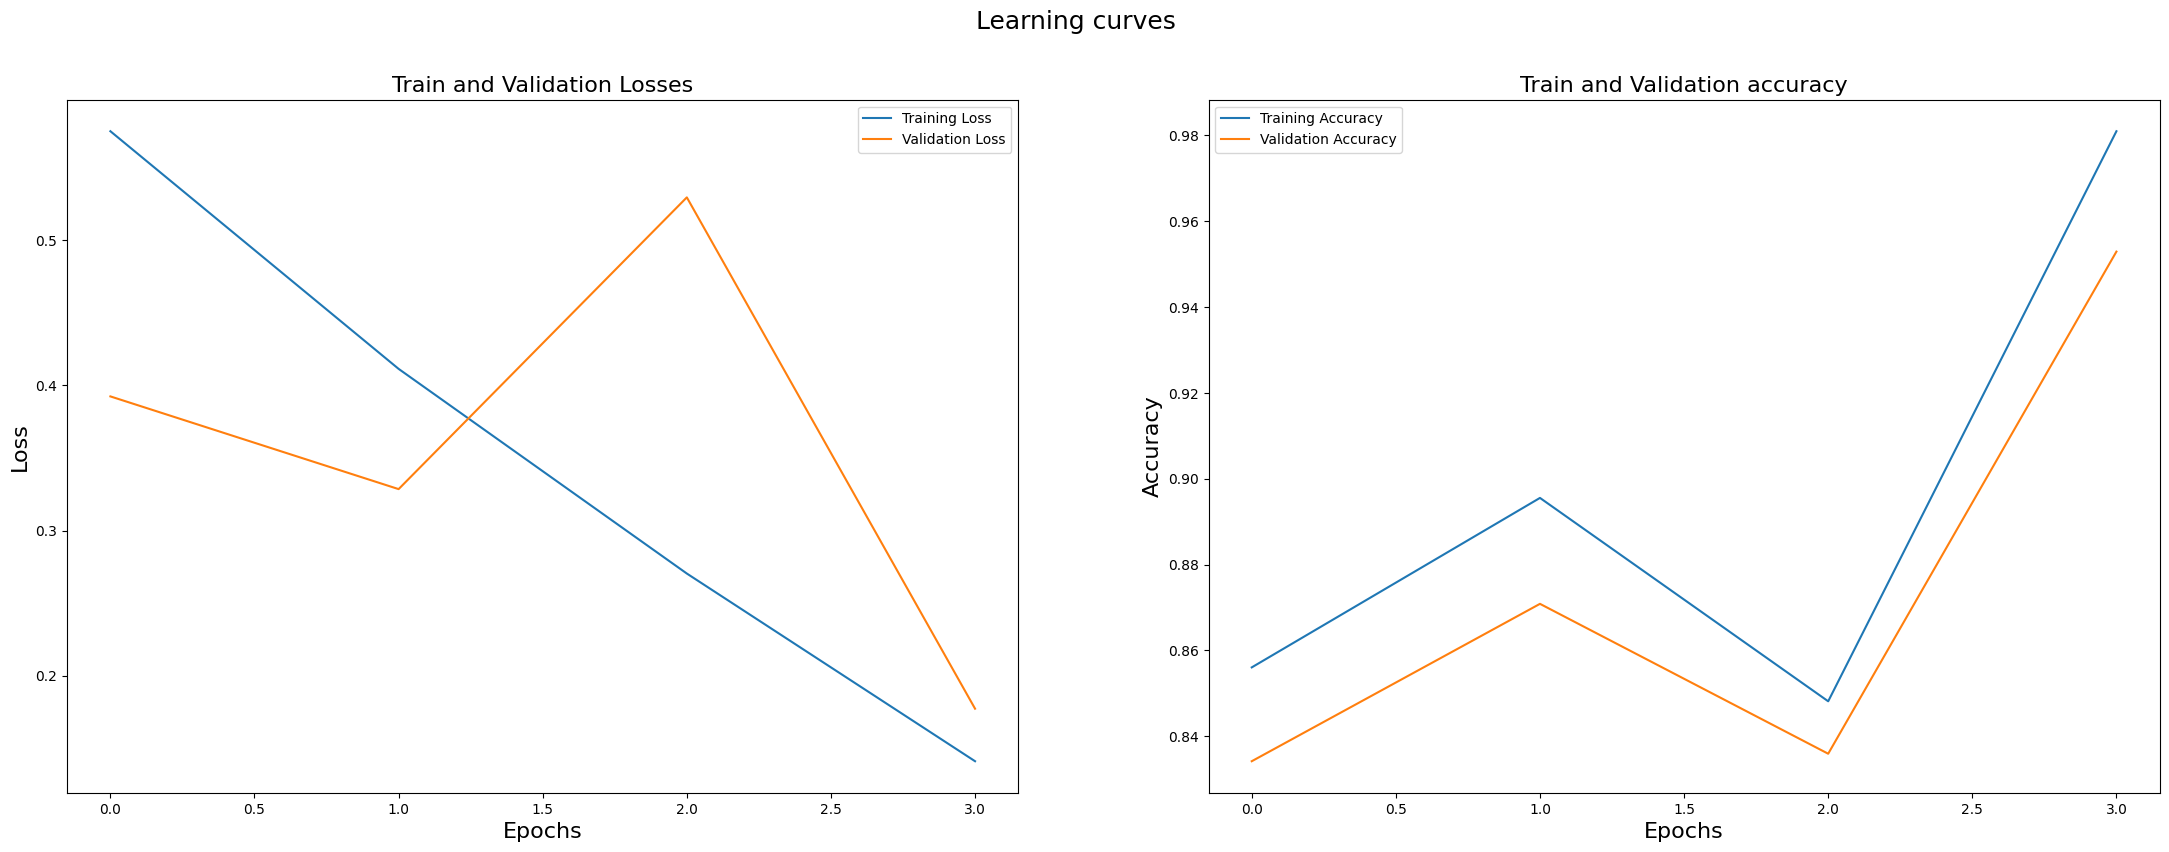

In [22]:
if cfg['model'].get('do_train', 1.0) > 0.0:
    print("Training...")
    bench_df = train_model(device,
                           model,
                           cfg,
                           classification_dataloader_train,
                           classification_dataloader_val,
                           saving_dir_model,
                           logger)

if cfg['model'].get('do_test', 1.0) > 0.0:
    print("Testing...")
    run_test(device,
             model,
             classification_dataloader_train,
             classification_dataloader_val,
             classification_dataloader_test,
             saving_dir_model,
             class_to_label)


In [23]:
# Validation slower? is it the size? - Yes!
bench_df['train_thpt'] = len(classification_dataloader_train.dataset) / bench_df['epoch_train_time']
bench_df['val_thpt'] = len(classification_dataloader_val.dataset) / bench_df['epoch_val_time']
bench_df['batch_size'] = cfg['dataset']['batch_size']
bench_df['num_workers'] = cfg['dataset']['num_workers']
bench_df['model'] = cfg['model']['name_pretrained_model']
bench_df['power_mode'] = cfg['benchmark']['power_mode']
bench_df['powermizer'] = cfg['benchmark']['powermizer']
bench_df['hdmi'] = cfg['benchmark']['hdmi']
bench_df['expo'] = cfg['benchmark'].get('expo', 1.0) > 0.0
bench_df['fan3'] = cfg['benchmark']['fan3']
bench_df['gpu_orient'] = 'vertical'
bench_df['pcie'] = cfg['benchmark']['pcie']
bench_df.head()

,cpu_temp,gpu_temp,gpu_power,gpu_graph_freq,gpu_sm_freq,gpu_mem_freq,gpu_vid_freq,gpu_p_state,epoch_train_time,epoch_frozen,...,val_thpt,batch_size,num_workers,model,power_mode,powermizer,hdmi,expo,fan3,gpu_orient
0,68.500,40,181.43,2775,2775,10802,2160,P2,16.471498,True,...,951.332170,32,8,resnet50,balanced,auto,gpu,True,70,vertical
1,68.625,41,183.23,2775,2775,10802,2160,P2,16.335119,True,...,895.834632,32,8,resnet50,balanced,auto,gpu,True,70,vertical
2,67.125,42,189.49,2775,2775,10802,2160,P2,45.096513,False,...,919.387250,32,8,resnet50,balanced,auto,gpu,True,70,vertical
3,67.625,44,203.31,2775,2775,10802,2160,P2,44.204655,False,...,929.072616,32,8,resnet50,balanced,auto,gpu,True,70,vertical


In [24]:
# Load and concatenate csv
def load_cat_csv(file_name, df_in=None):
    df = pd.read_csv(file_name)
    if df_in is not None: df = pd.concat([df, df_in], ignore_index=True)
    return df

In [25]:
# Concat different power modes
bench_df2 = load_cat_csv("./results/bench.csv", bench_df)
# bench_df2 = load_cat_csv("./results/bench.csv")
bench_df2.head(50)

,cpu_temp,gpu_temp,gpu_power,gpu_graph_freq,gpu_sm_freq,gpu_mem_freq,gpu_vid_freq,gpu_p_state,epoch_train_time,epoch_frozen,...,batch_size,num_workers,model,power_mode,powermizer,hdmi,expo,fan3,gpu_orient,pcie
0,68.750,41,181.91,2775,2775,10802,2160,P2,16.506727,True,...,32,8,resnet50,balanced,auto,gpu,True,70,horizontal,4-16x
1,69.625,42,183.18,2760,2760,10802,2160,P2,16.530525,True,...,32,8,resnet50,balanced,auto,gpu,True,70,horizontal,4-16x
2,71.000,44,201.19,2760,2760,10802,2160,P2,44.132806,False,...,32,8,resnet50,balanced,auto,gpu,True,70,horizontal,4-16x
3,71.625,45,200.93,2775,2775,10802,2160,P2,44.145911,False,...,32,8,resnet50,balanced,auto,gpu,True,70,horizontal,4-16x
4,69.250,41,183.48,2775,2775,10802,2160,P2,16.649613,True,...,32,8,resnet50,balanced,auto,cpu,True,70,horizontal,4-16x
5,70.875,42,181.51,2760,2760,10802,2160,P2,16.619789,True,...,32,8,resnet50,balanced,auto,cpu,True,70,horizontal,4-16x
6,72.000,44,201.24,2760,2760,10802,2160,P2,44.204088,False,...,32,8,resnet50,balanced,auto,cpu,True,70,horizontal,4-16x
7,70.625,46,201.2,2760,2760,10802,2145,P2,44.110932,False,...,32,8,resnet50,balanced,auto,cpu,True,70,horizontal,4-16x
8,70.500,40,182.89,2775,2775,10802,2160,P2,16.532998,True,...,32,8,resnet50,perf,auto,gpu,True,70,horizontal,4-16x
9,71.750,42,182.56,2760,2760,10802,2160,P2,16.529140,True,...,32,8,resnet50,perf,auto,gpu,True,70,horizontal,4-16x


In [26]:
bench_df2.to_csv("./results/bench.csv", index=False)

## Inference

In [108]:
print("Load the model")
model = ImageClassificationModel(cfg)

path_best_checkpoint = os.path.join(saving_dir_model, 'best.pth')
print("Load the best checkpoint: ", path_best_checkpoint)
checkpoint = torch.load(path_best_checkpoint, map_location=torch.device(device))
model.load_state_dict(checkpoint['model'])
model = model.eval()
model = model.to(device)

print("device: ", device)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
post_act = torch.nn.Softmax(dim=1)

label_to_class = {k: v for (v, k) in class_to_label.items()}

# load the image_byte
dataiter = iter(classification_dataloader_test)
images, labels = next(dataiter)

with torch.no_grad():
    outputs = model(images.to(device))
    # Get the predicted label
    preds = torch.softmax(outputs, dim=1)
    pred_values, pred_labels = torch.max(preds, 1)
    predicted_score = np.round(pred_values.cpu().numpy(), 4)
    predicted_class = list(map(label_to_class.get, pred_labels.cpu().numpy().tolist()))
    print("predicted_score: ", predicted_score)
    print("predicted_class: ", predicted_class)

Load the model
Freeze layers of pretrained model


Load the best checkpoint:  ./results/resnet50/models_aug/best.pth
device:  cuda:0
predicted_score:  [0.8627 0.7489 0.993  0.883  0.6463 0.9856 0.6316 0.9741 0.9219 0.8237
 0.678  0.7222 0.9871 0.9588 0.5048 0.9996 0.9993 0.9526 0.885  0.9998
 0.5767 0.8489 0.6533 0.8214 0.9999 0.9944 0.7435 0.9994 0.9448 0.9994
 0.9987 0.3949]
predicted_class:  ['meningioma_tumor', 'no_tumor', 'meningioma_tumor', 'meningioma_tumor', 'glioma_tumor', 'pituitary_tumor', 'meningioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'meningioma_tumor', 'no_tumor', 'meningioma_tumor', 'no_tumor', 'glioma_tumor', 'meningioma_tumor', 'no_tumor', 'meningioma_tumor', 'meningioma_tumor', 'meningioma_tumor', 'no_tumor', 'meningioma_tumor', 'meningioma_tumor', 'no_tumor', 'meningioma_tumor', 'no_tumor', 'meningioma_tumor', 'meningioma_tumor', 'no_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor', 'meningioma_tumor']
